In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_squared_error
import time
from drone_sim_utilities import quat_to_euler
from drone_sim_utilities import body_to_nav
from drone_sim_utilities import process_trajectory
from drone_sim_utilities import test_model

In [2]:
"""Training set creation"""

f = h5py.File('data/drone_sim/sunny.hdf5')
# Define trajectories to use for training
train_set = ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009',
             '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019']

data_params = {"MODEL_DELAY": 5, # Delay d for use in model
               "NORMALIZE_INPUT": 1, # Input normalized to mean=0, std=1
               "NORMALIZE_OUTPUT": 1, # Output normalized to mean=0, std=1
               "INPUT_ACCL": 1, # Use accelerometer as input
               "INPUT_GYRO": 1, # Use gyroscope as input
               "INPUT_ATTI": 1, # Use attitude as input
               "INPUT_VELO": 1, # Use velocity as input
               "INPUT_POUT": 1, # Use previous outputs as input
               "TRUE_ATT": 1, # Use groundtruth attitude, else estimate from gyros
               "TRUE_VEL": 0, # Use groundtruth velocity, else estimate from gyros
               "ACCEL_TO_NAV": 1
}

# Construct training data set
Y_train = np.zeros(shape=(0,3))
features = (data_params["INPUT_ACCL"] + data_params["INPUT_ATTI"] 
            + data_params["INPUT_GYRO"] + data_params["INPUT_POUT"] 
            + data_params["INPUT_VELO"])*3*data_params["MODEL_DELAY"]
X_train = np.zeros(shape=(0,features))
for i, traj_num in enumerate(train_set):
    traj_name = f"trajectory_{traj_num}"
    traj = f[traj_name]
    gps_delta, accel_data, gyro_data, attitude_data, velocity_data = process_trajectory(traj, data_params, train_mode=True)
    # Construct training set
    model_delay = data_params["MODEL_DELAY"]
    dp_ = gps_delta.shape[0]-model_delay
    Y_train_ = np.zeros(shape=(dp_, 3))
    X_train_ = np.zeros(shape=(dp_, features))
    # For each data point
    for i in range(dp_):
        # Construct output
        Y_ = gps_delta[i+model_delay,:]
        Y_train_[i,:] = Y_
        # Construct input
        X_ = np.zeros(shape=(1,0))
        if data_params["INPUT_ACCL"]:
            X_ = np.hstack((X_, [accel_data[i:i+model_delay,:].flatten()]))
        if data_params["INPUT_GYRO"]:
            X_ = np.hstack((X_, [gyro_data[i:i+model_delay,:].flatten()]))
        if data_params["INPUT_ATTI"]:
            X_ = np.hstack((X_, [attitude_data[i:i+model_delay,:].flatten()]))
        if data_params["INPUT_VELO"]:
            X_ = np.hstack((X_, [velocity_data[i:i+model_delay,:].flatten()]))
        if data_params["INPUT_POUT"]:
            X_ = np.hstack((X_, [gps_delta[i:i+model_delay,:].flatten()]))
        X_train_[i,:] = X_
    
    # Add to X and Y sets
    X_train = np.vstack((X_train, X_train_))
    Y_train = np.vstack((Y_train, Y_train_))

Train time: 0.0308


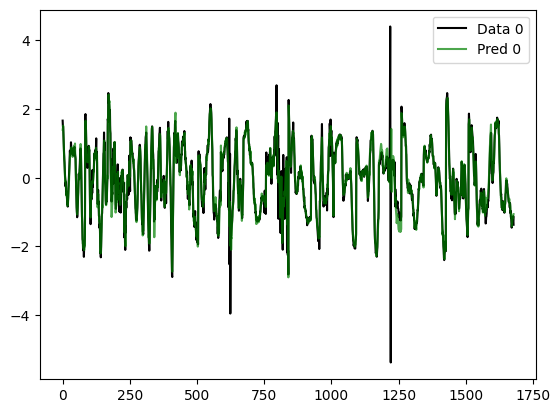

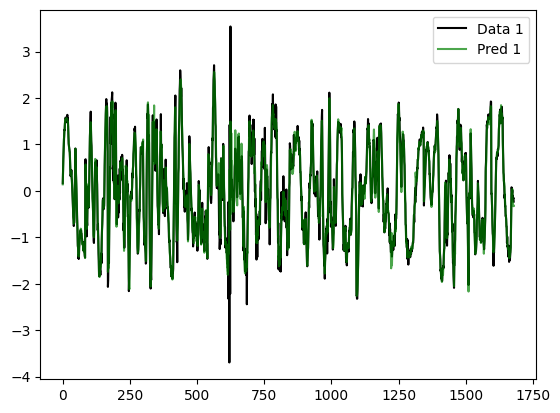

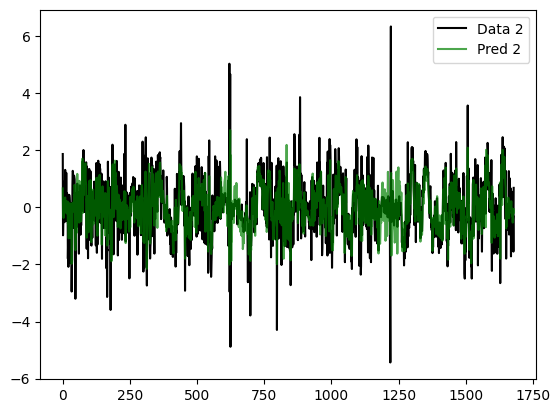

In [3]:
"""ARX model creation (training)"""

BETA_REG = 1e-5 # Regularization term

tic = time.time()
dp_, features_ = X_train.shape
_, outputs_ = Y_train.shape
w_ls = np.zeros(shape=(outputs_, features_, 1))
Y_train_ls = np.zeros(shape=(dp_, outputs_))
for i in range(outputs_):
    w_ls[i,:,:] = np.expand_dims(np.linalg.inv(X_train.T @ X_train + BETA_REG*np.eye(X_train.shape[1])) @ X_train.T @ Y_train[:,i], axis=1)
    Y_train_ls[:,i] = (X_train @ w_ls[i,:,:]).flatten()
toc = time.time()
print(f"Train time: {(toc-tic):.4f}")

# Create model (for use in evaluation)
def model_ls(x):
    outputs_, _, _ = w_ls.shape
    dp_, _ = x.shape
    y_ = np.zeros(shape=(dp_, outputs_))
    for i in range(outputs_):
        y_[:,i] = (x @ w_ls[i,:,:]).flatten()
    return y_

# Plot results of training
for i in range(Y_train.shape[1]):
    plt.figure()
    plt.plot(Y_train[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_train_ls[:,i], c="green", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

Epoch 1, training loss: 1.0977
Epoch 100, training loss: 0.3899
Epoch 200, training loss: 0.2754
Epoch 300, training loss: 0.2360
Epoch 400, training loss: 0.2192
Epoch 500, training loss: 0.2100
Epoch 600, training loss: 0.2034
Epoch 700, training loss: 0.1991
Epoch 800, training loss: 0.1953
Epoch 900, training loss: 0.1916
Epoch 1000, training loss: 0.1885
Training time: 3.0747


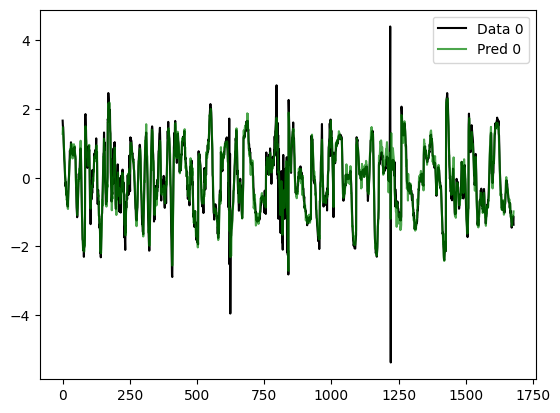

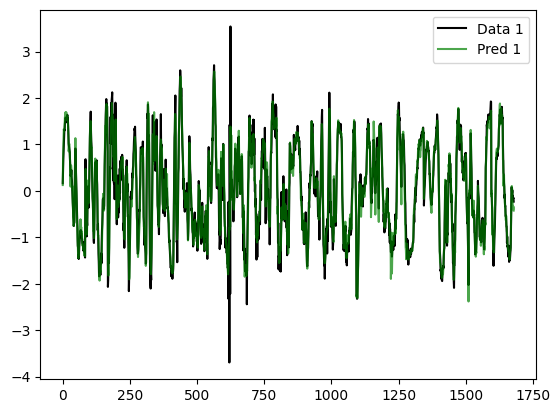

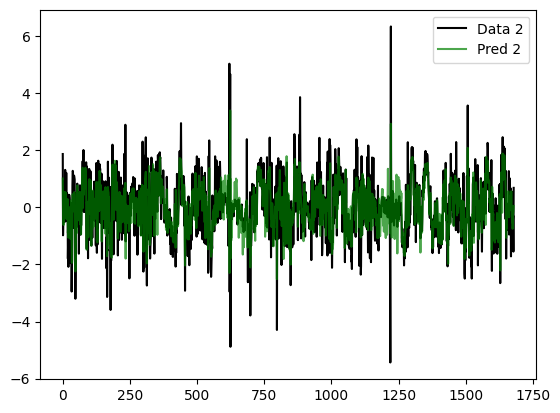

In [4]:
"""Neural network training"""

tic = time.time()
X_train_tensor = torch.from_numpy(X_train).to(torch.float32)
Y_train_tensor = torch.from_numpy(Y_train).to(torch.float32)

dp, features = X_train_tensor.shape
_, outputs = Y_train_tensor.shape

NUM_HIDDEN_LAYERS = 8 # Neurons in hidden layer
LEARNING_RATE = 1e-3 # Learning rate of descent algorithm
NUM_EPOCHS = 1000 # Number of training epochs

# Define model, loss function, and search algorithm
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=features, out_features=NUM_HIDDEN_LAYERS),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=NUM_HIDDEN_LAYERS, out_features=outputs)
)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train model
model.train()
for epoch in range(1, NUM_EPOCHS+1):
    Y_pred_ = model(X_train_tensor)
    loss_value = loss(Y_pred_, Y_train_tensor)

    model.zero_grad()
    loss_value.backward()
    optimizer.step()
    if (epoch == 1) or ((epoch % 100) == 0):
        print(f"Epoch {epoch}, training loss: {loss_value.item():.4f}")
toc = time.time()
print(f"Training time: {(toc-tic):.4f}")

# Evaluate train set
model.eval()
with torch.no_grad():
    Y_train_nn = model(X_train_tensor).numpy()

# Create NN model
def model_nn(x):
    x_tensor = torch.from_numpy(x).to(torch.float32)
    model.eval()
    with torch.no_grad():
        y_ = model(x_tensor).numpy()
    return y_

# Plot training results
for i in range(Y_train.shape[1]):
    plt.figure()
    plt.plot(Y_train[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_train_nn[:,i], c="green", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

In [5]:
"""
Neural network testing

Tests both ARX and NN models
"""

f = h5py.File('data/drone_sim/sunny.hdf5')
# Define trajectories for testing
test_set = ['0020', '0021', '0022', '0023', '0024', 
            '0025', '0026', '0027', '0028', '0029']
mse_ls_avg = np.zeros(shape=(3,))
mse_nn_avg = np.zeros(shape=(3,))
for traj_num in test_set:
    # Evaluate both model for the trajectory
    traj_name = f"trajectory_{traj_num}"
    traj = f[traj_name]
    Y_test_nn, Y_test = test_model(traj=traj, model=model_nn, data_params=data_params)
    Y_test_ls, _ = test_model(traj=traj, model=model_ls, data_params=data_params)
    
    # Get MSE for both models
    mse_ls = mean_squared_error(Y_test, Y_test_ls, multioutput="raw_values")
    mse_nn = mean_squared_error(Y_test, Y_test_nn, multioutput="raw_values")
    # Add to average
    mse_ls_avg = mse_ls_avg + mse_ls
    mse_nn_avg = mse_nn_avg + mse_nn

    # Print results
    print(f"\nTraj_{traj_num}")
    print(f"LS: x:{mean_squared_error(Y_test[:,0], Y_test_ls[:,0]):.4f} y:{mean_squared_error(Y_test[:,1], Y_test_ls[:,1]):.4f}, z:{mean_squared_error(Y_test[:,1], Y_test_ls[:,1]):.4f}")
    print(f"NN: x:{mean_squared_error(Y_test[:,0], Y_test_nn[:,0]):.4f} y:{mean_squared_error(Y_test[:,1], Y_test_nn[:,1]):.4f}, z:{mean_squared_error(Y_test[:,1], Y_test_nn[:,1]):.4f}")
mse_ls_avg = mse_ls_avg/len(test_set)
mse_nn_avg = mse_nn_avg/len(test_set)

# Print final MSE for both
print(f"NN: {mse_nn_avg}")
print(f"LS: {mse_ls_avg}")


Traj_0020
LS: x:0.0167 y:0.1273, z:0.1273
NN: x:0.0433 y:0.1041, z:0.1041

Traj_0021
LS: x:0.0846 y:0.0687, z:0.0687
NN: x:0.0570 y:0.0530, z:0.0530

Traj_0022
LS: x:0.0329 y:0.0566, z:0.0566
NN: x:0.0412 y:0.0416, z:0.0416

Traj_0023
LS: x:0.0481 y:0.0973, z:0.0973
NN: x:0.0841 y:0.0658, z:0.0658

Traj_0024
LS: x:0.3113 y:0.1977, z:0.1977
NN: x:0.2931 y:0.1892, z:0.1892

Traj_0025
LS: x:0.0146 y:0.0762, z:0.0762
NN: x:0.0396 y:0.0898, z:0.0898

Traj_0026
LS: x:0.0057 y:0.0415, z:0.0415
NN: x:0.0176 y:0.0401, z:0.0401

Traj_0027
LS: x:0.0216 y:0.0252, z:0.0252
NN: x:0.0434 y:0.0289, z:0.0289

Traj_0028
LS: x:0.0240 y:0.0228, z:0.0228
NN: x:0.0374 y:0.0226, z:0.0226

Traj_0029
LS: x:0.0151 y:0.0377, z:0.0377
NN: x:0.0300 y:0.0377, z:0.0377
NN: [0.0686706  0.0672688  0.99479632]
LS: [0.05746996 0.07510197 0.86979347]


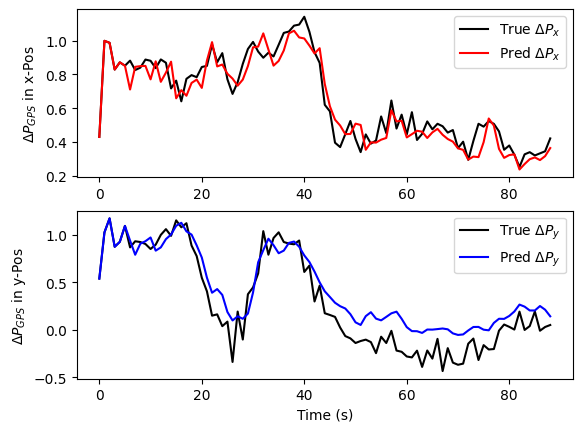

In [7]:
"""ARX results plotting"""

f = h5py.File('data/drone_sim/sunny.hdf5')
traj = f["trajectory_0026"]
Y_test_ls, Y_test = test_model(traj=traj, model=model_ls, data_params=data_params)

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(Y_test[:,0], c="black", label=r"True $\Delta P_{x}$")
ax[0].plot(Y_test_ls[:,0], c="red", label=r"Pred $\Delta P_{x}$")
ax[0].legend()
ax[0].set_ylabel(r"$\Delta P_{GPS}$ in x-Pos")

ax[1].plot(Y_test[:,1], c="black", label=r"True $\Delta P_{y}$")
ax[1].plot(Y_test_ls[:,1], c="blue", label=r"Pred $\Delta P_{y}$")
ax[1].legend()
ax[1].set_ylabel(r"$\Delta P_{GPS}$ in y-Pos")
ax[1].set_xlabel("Time (s)")
plt.show()

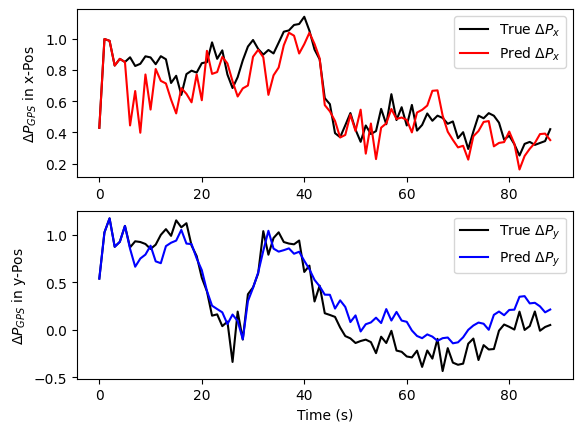

In [8]:
"""NN results plotting"""

f = h5py.File('data/drone_sim/sunny.hdf5')
traj = f["trajectory_0026"]
Y_test_nn, Y_test = test_model(traj=traj, model=model_nn, data_params=data_params)

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(Y_test[:,0], c="black", label=r"True $\Delta P_{x}$")
ax[0].plot(Y_test_nn[:,0], c="red", label=r"Pred $\Delta P_{x}$")
ax[0].legend()
ax[0].set_ylabel(r"$\Delta P_{GPS}$ in x-Pos")

ax[1].plot(Y_test[:,1], c="black", label=r"True $\Delta P_{y}$")
ax[1].plot(Y_test_nn[:,1], c="blue", label=r"Pred $\Delta P_{y}$")
ax[1].legend()
ax[1].set_ylabel(r"$\Delta P_{GPS}$ in y-Pos")
ax[1].set_xlabel("Time (s)")
plt.show()